<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigment 1 execution

Corpora: https://www.nltk.org/nltk_data/ , point 91, "Dependency Parsed Treebank" ([link](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip)).

Docs:
* https://www.nltk.org/api/nltk.corpus.html
* https://www.nltk.org/data.html
* https://www.nltk.org/install.html

## Preparing the environment

In [1]:
%pip install pandas numpy matplotlib gensim==4.2.0 tensorflow-addons pydot

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import re
import urllib.request  # download files
from zipfile import ZipFile # extract files
from matplotlib import pyplot as plt
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
import keras

2023-01-06 14:22:31.522139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 14:22:31.761424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 14:22:31.761524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-06 14:22:31.805409: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-06 14:22:32.522290: W tensorflow/stream_executor/platform/de

## Downloading the dataset

In [3]:
#from nltk import download
#download()

In [4]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")
    
with ZipFile(dataset_path, 'r') as zObject:
  # Extracting all the members of the zip  into a specific location.
  zObject.extractall(dataset_folder)
  print("Successful extraction")

Successful extraction


## Loading the data

In [5]:
#from nltk.corpus import dependency_treebank
#from nltk.data import load
#dependency_treebank_test = load("nltk:") 
#sentences = dependency_treebank.sents()
#words = dependency_treebank.words()

In [6]:
def loadCorpus(start:int, stop:int=None):
    '''
    Loads the data for the specified file range.
    
    Removes the third column 'num', which is not necessary for this task.

    Parameters:
        start: start of numeric range of files (inclusive)
        stop: end of numeric range of files (exclusive)
    '''
    dataset_name = "dependency_treebank"
    folder = os.path.join(os.getcwd(), "Dataset", dataset_name)

    if stop==None:
        stop = start+1
    
    return pd.concat([
        pd.read_csv(
            f'{folder}/wsj_{"{:04d}".format(num)}.dp',
            sep="\t",
            usecols=[0,1],
            names=["word","label"]
        ) for num in range(start, stop)
    ])

In [7]:
full_dataset = loadCorpus(1,200)

## Exploratory Data Analysis

In [8]:
full_dataset.count()

word     94084
label    94084
dtype: int64

In [9]:
full_dataset.head(20)

,word,label
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


Each document contains a different tokenized article:

In [10]:
sample_article = loadCorpus(1)
" ".join(sample_article["word"])

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [11]:
" ".join(loadCorpus(2)["word"])

'Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .'

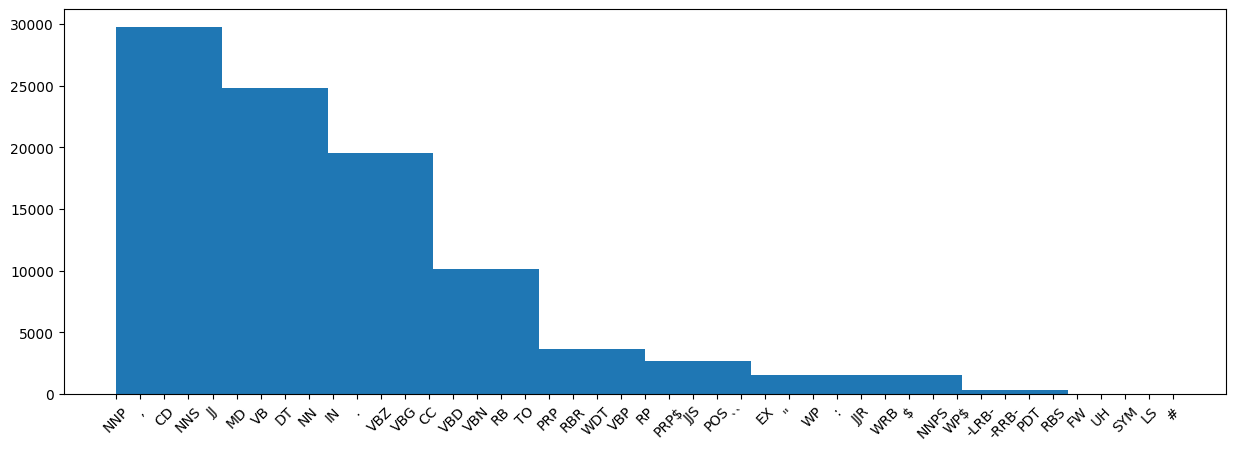

In [12]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(full_dataset["label"])
plt.xticks(rotation=45)
plt.show()

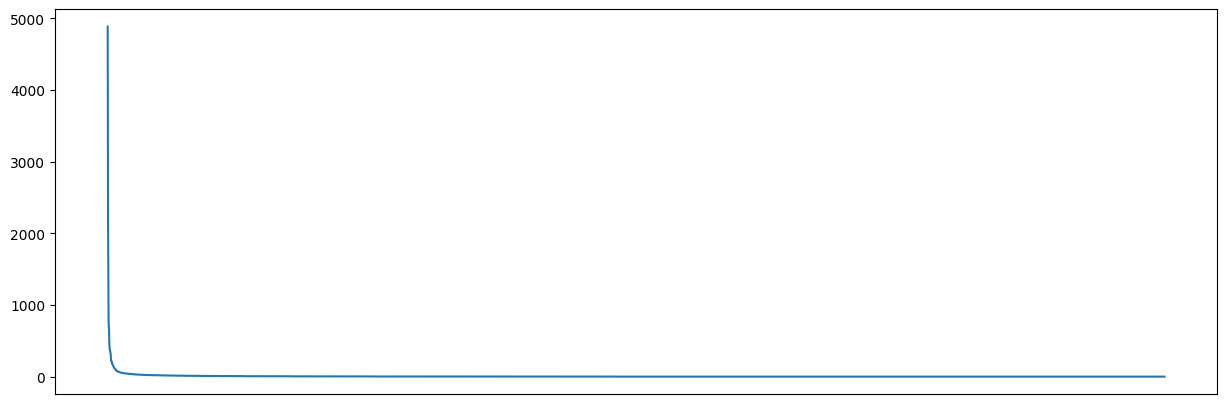

In [13]:
fig=plt.figure(figsize=(15,5))
p = plt.plot(full_dataset["word"].value_counts())
plt.xticks([])
plt.show()

## Data splitting





Creation of train, validation and test sets.

In [14]:
df_train = loadCorpus(1,101) 
df_val = loadCorpus(101,151)
df_test = loadCorpus(151,200)

df_train.count()

word     47356
label    47356
dtype: int64

In [15]:
df_val.count()

word     31183
label    31183
dtype: int64

In [16]:
df_test.count()

word     15545
label    15545
dtype: int64

## Data pre-processing

Clean the data.

In [17]:
# Filter out punctuation based on the class
punctuation_classes = [ # https://universaldependencies.org/docs/en/pos/all.html#al-en-pos/PUNCT
    "``", "’’", "-LRB-", "-RRB-", ",", ".", ":", "HYPH", # PUNCT: punctuation
    "#", "$", "SYM", # SYM: symbol
    "''", # Custom
]
def cleanCorpus(corpus):
    # # Filter out punctuation based on the word
    # corpus["word"] = [re.sub(r'[^\w]', '', word) for word in corpus["word"]]
    # corpus = corpus[corpus["word"] != ""]
    #corpus = corpus[~corpus["label"].isin(punctuation_classes)]
    
    corpus['word'] = corpus['word'].str.lower()
    return corpus

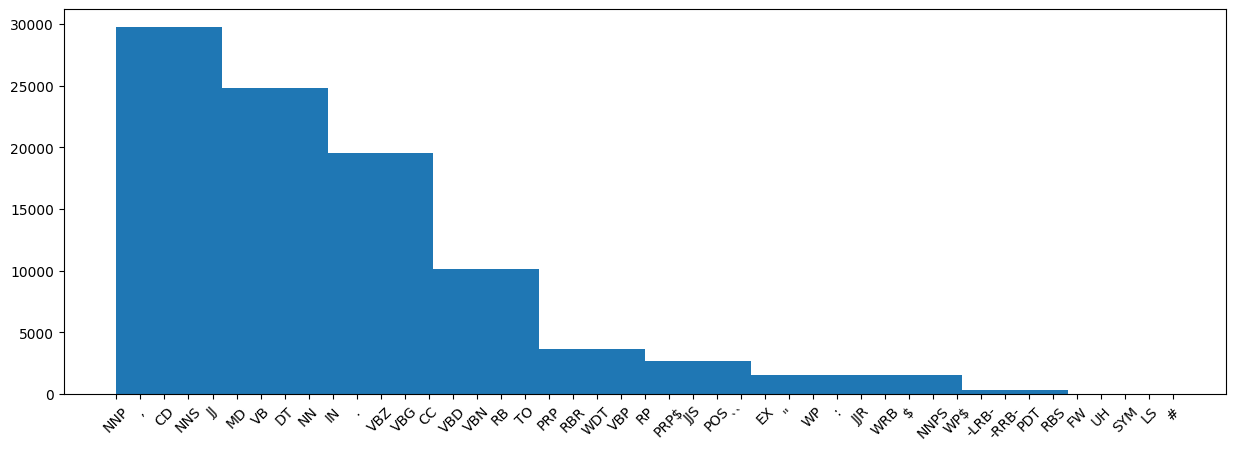

In [18]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(cleanCorpus(full_dataset)["label"])
plt.xticks(rotation=45)
plt.show()

In [19]:
#cleaned dataframes
dfc_train = cleanCorpus(df_train)
dfc_val = cleanCorpus(df_val)
dfc_test = cleanCorpus(df_test)
dfc_sample = cleanCorpus(sample_article)

dfc_train.count()

word     47356
label    47356
dtype: int64

In [20]:
dfc_val.count()

word     31183
label    31183
dtype: int64

In [21]:
dfc_test.count()

word     15545
label    15545
dtype: int64

In [22]:
dfc_train.head(20)

,word,label
0,pierre,NNP
1,vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


## Word embedding

### Loading GloVe


Loading pre-trained dense word embedding representation: GloVe.






In [23]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [24]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300 (200 seems the better)
# Word2Vec -> 300
# Fasttext -> 300
embedding_dimension = 200
embedding_model = load_embedding_model(model_type="glove", embedding_dimension= embedding_dimension)

### Analyzing OOV statistics

In [25]:
embedding_model.index_to_key[0:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [26]:
oov_train = list(set([word for word in dfc_train.word.values if word not in embedding_model.index_to_key]))
oov_val = list(set([word for word in dfc_val.word.values if word not in embedding_model.index_to_key]))
oov_test = list(set([word for word in dfc_test.word.values if word not in embedding_model.index_to_key]))
print(f'oov_train_size: {len(oov_train)}')
print(f'oov_val_size: {len(oov_val)}')
print(f'oov_test_size: {len(oov_test)}')

oov_train_size: 359
oov_val_size: 213
oov_test_size: 161


In [27]:
oov_train[0:10]

['37-a-share',
 'bermuda-based',
 'anti-takeover',
 'lezovich',
 'test-prep',
 'sub-markets',
 'thin-lipped',
 'lap-shoulder',
 'uzi-model',
 '38.375']

### GloVe Embedding

#### Prepare the embedding matrix

In [28]:
def deal_OOV(vectors, vocabulary, embedding_dimension, oov_set):
  #deal with oov words by adding a random embedding vector to the embedding matrix
  for idx in range(0, len(oov_set)):
    if oov_set[idx] not in vocabulary:
      vocabulary.append(oov_set[idx])
      #use random embedding for OOV word
      embedding_vector = np.random.uniform(low=-0.05, high=0.05, size= embedding_dimension)
      vectors.append(embedding_vector)
  return vocabulary, vectors

In [29]:
#GloVe vocabulary
words = list(embedding_model.index_to_key)
#extracting the GloVe embedding vectors
vectors = [embedding_model[word] for word in words]
em0 =np.array([0.0]*embedding_dimension)
vectors.insert(0, em0)

#deal with train oov words
vocab, vectors = deal_OOV(vectors, words, embedding_dimension, oov_train)
#deal with validation oov words
vocab, vectors = deal_OOV(vectors, vocab, embedding_dimension, oov_val)
#deal with test oov words
vocab, vectors = deal_OOV(vectors, vocab, embedding_dimension, oov_test)

embedding_matrix = np.asarray(vectors)
print(np.shape(embedding_matrix))


(400677, 200)


Define a tokenizer.

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer, removing the default filters: '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' 
tokenizer = Tokenizer(filters='')
#text = dfc_train.word.values
#fit the tokenizer on the vocabulary of GloVe, including also the OOV words 
tokenizer.fit_on_texts(vocab)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:50]))

Number of unique words in dictionary= 400676
Dictionary head:  {'the': 1, ',': 2, '.': 3, 'of': 4, 'to': 5, 'and': 6, 'in': 7, 'a': 8, '"': 9, "'s": 10, 'for': 11, '-': 12, 'that': 13, 'on': 14, 'is': 15, 'was': 16, 'said': 17, 'with': 18, 'he': 19, 'as': 20, 'it': 21, 'by': 22, 'at': 23, '(': 24, ')': 25, 'from': 26, 'his': 27, "''": 28, '``': 29, 'an': 30, 'be': 31, 'has': 32, 'are': 33, 'have': 34, 'but': 35, 'were': 36, 'not': 37, 'this': 38, 'who': 39, 'they': 40, 'had': 41, 'i': 42, 'which': 43, 'will': 44, 'their': 45, ':': 46, 'or': 47, 'its': 48, 'one': 49, 'after': 50}


In [31]:
"""
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
text = dfc_train.word.values

#fit the tokenizer on the training data
tokenizer.fit_on_texts(text)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))
"""

'\nfrom tensorflow.keras.preprocessing.text import Tokenizer\n\n# define the tokenizer\ntokenizer = Tokenizer(oov_token=\'<unk>\')\ntext = dfc_train.word.values\n\n#fit the tokenizer on the training data\ntokenizer.fit_on_texts(text)\n\n# number of unique words in dict.\nprint("Number of unique words in dictionary=", len(tokenizer.word_index))\nprint("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))\n'

In [32]:
with open('./Dataset/word_index.json','w') as word_index_file:
    word_index_file.write(tokenizer.to_json())

Define the embedding matrix.

In [33]:
#remove it after we are sure about the correctness of the embedding done above 
"""
from tqdm import tqdm

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(tokenizer.word_index.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            #print(f"Using random vector for '{word}'")
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix
"""

'\nfrom tqdm import tqdm\n\ndef build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,\n                           embedding_dimension: int,\n                           word_to_idx,\n                           vocab_size: int) -> np.ndarray:\n    \n    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model\n\n    :param embedding_model: pre-trained word embedding model (gensim wrapper)\n    :param word_to_idx: vocabulary map (word -> index) (dict)\n    :param vocab_size: size of the vocabulary\n    \n\n    :return\n        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)\n    \n    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)\n    for word, idx in tqdm(tokenizer.word_index.items()):\n        try:\n            embedding_vector = embedding_model[word]\n        except (KeyError, TypeError):\n            #print(f"Using ra

In [34]:
"""
# Testing
embedding_dimension = 50
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index, vocab_size )
print(f"Embedding matrix shape: {embedding_matrix.shape}")
"""

'\n# Testing\nembedding_dimension = 50\nvocab_size = len(tokenizer.word_index) + 1\nembedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index, vocab_size )\nprint(f"Embedding matrix shape: {embedding_matrix.shape}")\n'

#### Encode the dataset

Define a label encoder for the target class.

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
dfc_val['encoded_label'] = le.transform(dfc_val['label'])
dfc_test['encoded_label'] = le.transform(dfc_test['label'])
dfc_sample['encoded_label'] = le.transform(dfc_sample['label'])

In [36]:
dfc_train.head(20)

,word,label,encoded_label
0,pierre,NNP,20
1,vinken,NNP,20
2,",",",",3
3,61,CD,9
4,years,NNS,22
5,old,JJ,14
6,",",",",3
7,will,MD,18
8,join,VB,34
9,the,DT,10


In [37]:
# Select all the unique classes in the dataframe and their encoding
labels = dfc_train.drop_duplicates(['label','encoded_label'])[['label','encoded_label']]
# Extracting the encoded label vector for all punctuation and symbols. Will be used in F1 score calculation   
# The vector is defined in the cleanCorpus function.
# , . `` '' : $ -LRB- -RRB- SYM #
# [3,6,44,2,7,1,4,5,31,0]
punctuation_labels = labels[labels.label.isin(punctuation_classes)]['encoded_label'].values

print(f"Punctation labels: {punctuation_labels}")

Punctation labels: [ 3  6 44  2  7  1  4  5 31  0]


Transform the text into a sequence of integers using the tokenizer defined before. 

In [38]:
x_train = np.array(tokenizer.texts_to_sequences(list(dfc_train.word.values))) 
y_train = np.array( dfc_train['encoded_label'])

x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
y_val = np.array(dfc_val['encoded_label'])

x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))
y_test = np.array(dfc_test['encoded_label'])

x_sample = np.array(tokenizer.texts_to_sequences(dfc_sample.word.values))
y_sample = np.array(dfc_sample['encoded_label'])

#number of unique labels
num_classes = len(np.unique(y_train))
num_classes

45

Pad the sequences to make them of same length before passing them to the model.

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=1, padding='post')
x_val = pad_sequences(x_val, maxlen=1, padding='post')
x_test = pad_sequences(x_test, maxlen=1, padding='post')
x_sample = pad_sequences(x_sample, maxlen=1, padding='post')

#Train
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')
print(f'type:{type(x_train)}')

# Val
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')
print(f'type:{type(y_train)}')
# Test

print(f'X test shape: {x_test.shape}', x_test.shape)
print(f'Y test shape: {y_test.shape}', y_test.shape)

X train shape: (47356, 1)
Y train shape: (47356,)
type:<class 'numpy.ndarray'>
X val shape: (31183, 1)
Y val shape: (31183,)
type:<class 'numpy.ndarray'>
X test shape: (15545, 1) (15545, 1)
Y test shape: (15545,) (15545,)


In [40]:
vocab_size = len(tokenizer.word_index) + 1

## Utility methods

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

In [42]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [43]:
def create_model(layers_info: List[Dict], compile_info: Dict) -> keras.Model:
    """
    Create a Keras model given a list of layer information

    :param layers_info: a list of dictionaries, one for each layer
    :param compile_info: dictionary containing compile information

    :return
        model: the built keras sequential model
    """
    set_reproducibility(42)
    model = keras.Sequential()
    for _, info in enumerate(layers_info):
        layer = info['mlayer'](**{key: value for key, value in info.items() if key != 'mlayer'})
        model.add(layer)

    model.summary()
    model.compile(**compile_info)
    return model

In [44]:
import matplotlib.pyplot as plt
from functools import partial
from keras.callbacks import History

def show_history(history: History, name:str):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")
    
    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
            plt.grid(True)
            fig.savefig(f'./report/{name}_{key}.png')
            fig.show()


In [45]:
from tensorflow.keras.utils import plot_model

def train_model(model: keras.Model, training_info: Dict, name:str):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    plot_model(model, to_file=f"./report/{name}_model.png", show_layer_names=True, show_shapes=True)

    print(f"Start training! \nParameters: {training_info}")

    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed!")

    print("Showing history...")
    show_history(history, name)

    return model

In [46]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [47]:
from sklearn.metrics import f1_score

def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    
    #compute the f1_macro exluding puntuaction labels

    labels = np.unique( np.concatenate((np.unique(y), np.unique(y_pred))))
    labels = [label for label in labels if label not in punctuation_labels]
    #print(labels)

    score = f1_score(y, y_pred, average ='macro', labels=labels)
    return score

## Baseline model: LSTM

### Define the model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 
from tensorflow.keras.optimizers import Adam

base_layers_info = [
    {
        "mlayer": layers.Embedding,        
        'input_dim': vocab_size,
        "output_dim" : embedding_dimension,
        "input_length" : 1,
        "weights" : [embedding_matrix],
        "trainable" : False,
        "name" : "embedding_layer"
    },
    {
        "mlayer": layers.Bidirectional,
        "layer": LSTM(128, activation="tanh"),
        "name" : 'LSTM'
    },
    {
        "mlayer": layers.Dense,
        "units": num_classes,
        "activation" : 'softmax',
        'name' : 'logits'
    }
]

base_compile_info = {
    'optimizer': Adam(),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}

base_model = create_model(base_layers_info, base_compile_info)

2023-01-06 14:23:38.905616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-06 14:23:38.906014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 14:23:38.906108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-06 14:23:38.906441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-06 14:23:38.918119: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 1, 200)           80135400  
                                                                 
 LSTM (Bidirectional)        (None, 256)               336896    
                                                                 
 logits (Dense)              (None, 45)                11565     
                                                                 
Total params: 80,483,861
Trainable params: 348,461
Non-trainable params: 80,135,400
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/tmp/ipykernel_21701/3500274068.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


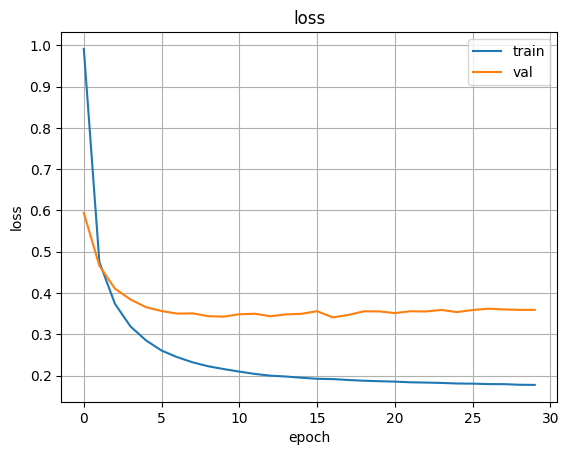

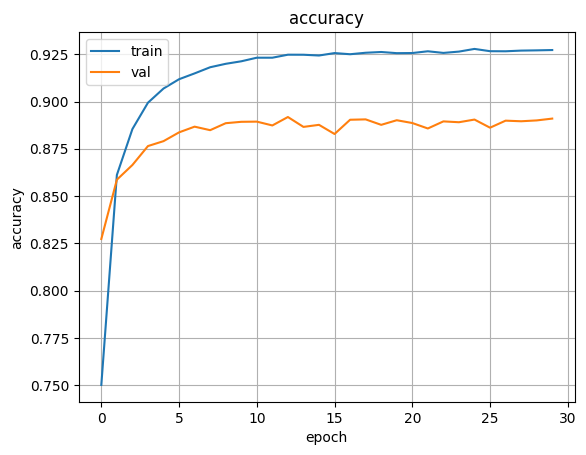

In [49]:
# Train
 
base_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64
}

base_model = train_model(model=base_model,training_info = base_training_info, name="base")

#### F1-Macro evaluation

In [50]:
loss, accuracy = base_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

base_score = compute_f1(base_model, x_val, y_val)
print(f'F1_score on the validation set is: {base_score}')

base_score = compute_f1(base_model, x_test, y_test)
print(f'F1_score on the test set is: {base_score}')

975/975 [==============================] - 3s 3ms/step - loss: 0.3591 - accuracy: 0.8910
Model loss: 0.35907700657844543, accuracy: 0.8909662365913391
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 3ms/step
F1_score on the validation set is: 0.7021385582569629
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 1s 3ms/step
F1_score on the test set is: 0.7783847353968951


#### Sample test

In [51]:
x_sample_text = tokenizer.sequences_to_texts(x_sample)
y_pred_sample_onehot = base_model.predict(x_sample)
y_pred_sample = np.argmax(y_pred_sample_onehot, axis=1)
for i in range(x_sample.size):
    print(f"{y_pred_sample[i]} \t {y_sample[i]} \t {'ok' if y_pred_sample[i]==y_sample[i] else 'ERR'} \t {x_sample_text[i]}")

1/1 [==============================] - 0s 26ms/step
20 	 20 	 ok 	 pierre
20 	 20 	 ok 	 vinken
3 	 3 	 ok 	 ,
9 	 9 	 ok 	 61
22 	 22 	 ok 	 years
14 	 14 	 ok 	 old
3 	 3 	 ok 	 ,
18 	 18 	 ok 	 will
34 	 34 	 ok 	 join
10 	 10 	 ok 	 the
19 	 19 	 ok 	 board
13 	 13 	 ok 	 as
10 	 10 	 ok 	 a
14 	 14 	 ok 	 nonexecutive
19 	 19 	 ok 	 director
20 	 20 	 ok 	 nov.
9 	 9 	 ok 	 29
6 	 6 	 ok 	 .
20 	 20 	 ok 	 mr.
20 	 20 	 ok 	 vinken
39 	 39 	 ok 	 is
19 	 19 	 ok 	 chairman
13 	 13 	 ok 	 of
20 	 20 	 ok 	 elsevier
20 	 20 	 ok 	 n.v.
3 	 3 	 ok 	 ,
10 	 10 	 ok 	 the
20 	 20 	 ok 	 dutch
36 	 36 	 ok 	 publishing
19 	 19 	 ok 	 group
6 	 6 	 ok 	 .


## Model A: GRU

GRU is a simpler alternative to LSTM's architecture, less effective but with a faster train.
</br>Two layers architecture: a Bidirectional GRU layer and a Dense/FC layer on top. 

In [52]:
# Create model

from tensorflow.keras.layers import GRU

gru_layers_info = [
    {
        "mlayer": layers.Embedding,
        "output_dim" : embedding_dimension,
        "input_dim" : vocab_size,
        "input_length" : 1,
        "weights" : [embedding_matrix],
        "trainable" : False,
        "name" : "embedding"
    },
    {
        "mlayer": layers.Bidirectional,
        "layer": GRU(32, activation="tanh") , 
        'name' : 'GRU'     
    },
    {
        "mlayer": layers.Dense,
        "units":num_classes,
        "activation" : 'softmax',
        'name' : 'logits'
    }
]

gru_compile_info = {
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}

gru_model = create_model(gru_layers_info, gru_compile_info)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 200)            80135400  
                                                                 
 GRU (Bidirectional)         (None, 64)                44928     
                                                                 
 logits (Dense)              (None, 45)                2925      
                                                                 
Total params: 80,183,253
Trainable params: 47,853
Non-trainable params: 80,135,400
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/tmp/ipykernel_21701/3500274068.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


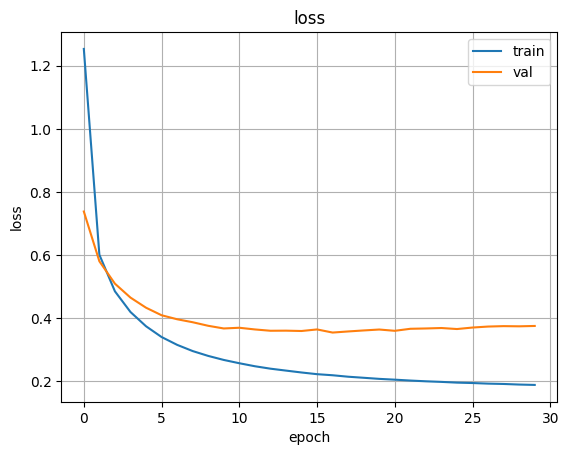

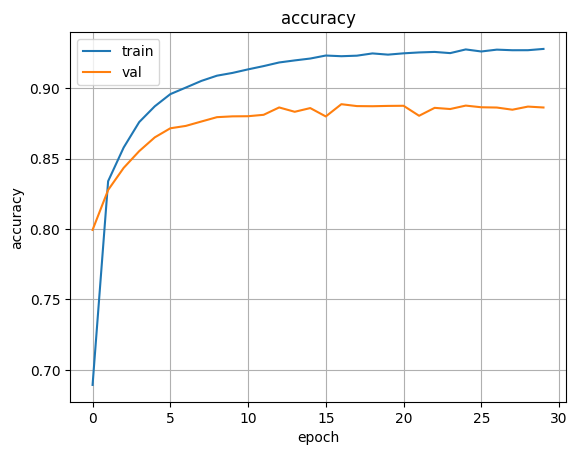

In [53]:
# Train
 
gru_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64
}

gru_model = train_model(model=gru_model,training_info = gru_training_info, name="gru")

#### F1-Macro evaluation

In [54]:
loss, accuracy = gru_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

gru_score = compute_f1(gru_model, x_val, y_val)
print(f'F1_score on the validation set is: {gru_score}')

gru_score = compute_f1(gru_model, x_test, y_test)
print(f'F1_score on the test set is: {gru_score}')

975/975 [==============================] - 2s 2ms/step - loss: 0.3753 - accuracy: 0.8862
Model loss: 0.37529492378234863, accuracy: 0.8861879706382751
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 2ms/step
F1_score on the validation set is: 0.7159728999838707
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 1s 2ms/step
F1_score on the test set is: 0.797299904507028


## Model B: 2x LSTM 

A dictionary with some hyperparameters to test on the LSTM layers. At the end of the process, for each of the models, the f1_macro will be printed.

In [55]:
hp_b = {
    'hp1_1' : {
        'lstm_1' : {
            'units' : 14,
            'return_sequences' : True,
            'dropout' : 0.1
        },
        'lstm_2' : {
            'units' : 28,
            'return_sequences' : False,
            'dropout' : 0.1
        },
        'learning_rate' : 1.5e-3
    },
    'hp1_2' : {
        'lstm_1' : {
            'units' : 14,
            'return_sequences' : True,
            'dropout' : 0
        },
        'lstm_2' : {
            'units' : 28,
            'return_sequences' : False,
            'dropout' : 0
        },
        'learning_rate' : 1.5e-3
    },
    'hp2_1' : {
        'lstm_1' : {
            'units' : 28,
            'return_sequences' : True,
            'dropout' : 0.1
        },
        'lstm_2' : {
            'units' : 14,
            'return_sequences' : False,
            'dropout' : 0.1
        },
        'learning_rate' : 1.5e-3
    },
    'hp2_2' : {
        'lstm_1' : {
            'units' : 28,
            'return_sequences' : True,
            'dropout' : 0
        },
        'lstm_2' : {
            'units' : 14,
            'return_sequences' : False,
            'dropout' : 0
        },
        'learning_rate' : 1.5e-3
    },
    'hp3' : {
        'lstm_1' : {
            'units' : 128,
            'return_sequences' : True,
            'dropout' : 0
        },
        'lstm_2' : {
            'units' : 128,
            'return_sequences' : False,
            'dropout' : 0
        },
        'learning_rate' : 1.0e-3
    }
    
}

This array will store all the f1_scores calculated with the compute_f1 function.

In [56]:
results_x2lstm = []

Setup of the loop for creation, fit, evaluation of the 2xLSTM models with the dictionary of hyperparameters.

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 
from keras.optimizers import Adam


for key,idx in zip(hp_b.keys(),range(0,5)):
    l1 = hp_b[key]['lstm_1']
    l2 = hp_b[key]['lstm_2']
    learning_rate = hp_b[key]['learning_rate']

    set_reproducibility(42)
    x2lstm_model = Sequential()
    embedding_layer = Embedding(input_dim = vocab_size,output_dim= embedding_dimension,input_length=1, weights = [embedding_matrix], trainable = False)
    x2lstm_model.add(embedding_layer)
    x2lstm_model.add(Bidirectional(LSTM(
                                    units=l1['units'], 
                                    activation="tanh",
                                    return_sequences=l1['return_sequences'],
                                    dropout=l1['dropout'])))
    
    x2lstm_model.add(Bidirectional(LSTM(
                                    units=l2['units'], 
                                    activation="tanh",
                                    return_sequences=l2['return_sequences'],
                                    dropout=l2['dropout'])))
    x2lstm_model.add(Dense(num_classes,activation='softmax'))

    x2lstm_model.summary()

    x2lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    plot_model(x2lstm_model, to_file="./report/x2lstm_model.png", show_layer_names=True, show_shapes=True)

    # fit model
    history = x2lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 128, epochs=30)
    print('='*40,key,'='*40)
    #show_history(history)
    #x2lstm_model.evaluate(x_val, y_val)
    #results_x2lstm.append(f1_macro(x2lstm_model, y_train, y_val, num_classes))
   
    loss, accuracy = x2lstm_model.evaluate(x_val, y_val)
    print(f"Model loss: {loss}, accuracy: {accuracy}")

    # Inference and evaluate

    x2lstm_score = compute_f1(x2lstm_model, x_val, y_val)
    print(f'F1_score on the validation set is: {x2lstm_score}')

    x2lstm_score = compute_f1(x2lstm_model, x_test, y_test)
    print(f'F1_score on the test set is: {x2lstm_score}')

    results_x2lstm.append(x2lstm_score.copy())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 200)            80135400  
                                                                 
 bidirectional (Bidirectiona  (None, 1, 28)            24080     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 56)               12768     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 45)                2565      
                                                                 
Total params: 80,174,813
Trainable params: 39,413
Non-trainable params: 80,135,400
_________________________________________________________________
Epoch 1/30
370/370 [=================

In [58]:
print("F1_SCORES")
for f1_macro_score,idx in zip(results_x2lstm,range(0,5)):
    print(idx, " ", f1_macro_score)

F1_SCORES
0   0.7710120789162613
1   0.7820999601777181
2   0.783907137981553
3   0.7729428930892979
4   0.7779752490568717


In [59]:
x2lstm_score = max([f1_macro_score for f1_macro_score,idx in zip(results_x2lstm,range(0,5))])
print(f"Top 2xLSTM F1 Macro score: {x2lstm_score}")

Top 2xLSTM F1 Macro score: 0.783907137981553


In [60]:
#from keras.optimizers import Adam

#x2lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=2e-3), metrics=['accuracy'])

In [61]:
# fit model
#history = x2lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 128, epochs=30)

In [62]:
#show_history(history)

In [63]:
#x2lstm_model.evaluate(x_val, y_val)

## Model C: LSTM + Dense

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 
from tensorflow.keras.optimizers import Adam

lstm_dense_layers_info = [
    {
        "mlayer": layers.Embedding,        
        'input_dim': vocab_size,
        "output_dim" : embedding_dimension,
        "input_length" : 1,
        "weights" : [embedding_matrix],
        "trainable" : False,
        "name" : "embedding_layer"
    },
    {
        "mlayer": layers.Bidirectional,
        "layer": LSTM(128, activation="tanh"),
        "name" : 'LSTM_layer'
    },
    {
        "mlayer": layers.Dropout,
        "rate": .3,
        "name" : 'dropout_layer'
    },
    {
        "mlayer": layers.Dense,
        "name" : 'dense_layer',
        "activation": "relu",
        "units": 1000,
    },
    {
        "mlayer": layers.Dense,
        "units": num_classes,
        "activation" : 'softmax',
        'name' : 'logits'
    }
]

lstm_dense_compile_info = {
    'optimizer': Adam(),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}

lstm_dense_model = create_model(lstm_dense_layers_info, lstm_dense_compile_info)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 1, 200)           80135400  
                                                                 
 LSTM_layer (Bidirectional)  (None, 256)               336896    
                                                                 
 dropout_layer (Dropout)     (None, 256)               0         
                                                                 
 dense_layer (Dense)         (None, 1000)              257000    
                                                                 
 logits (Dense)              (None, 45)                45045     
                                                                 
Total params: 80,774,341
Trainable params: 638,941
Non-trainable params: 80,135,400
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 20, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/tmp/ipykernel_21701/3500274068.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


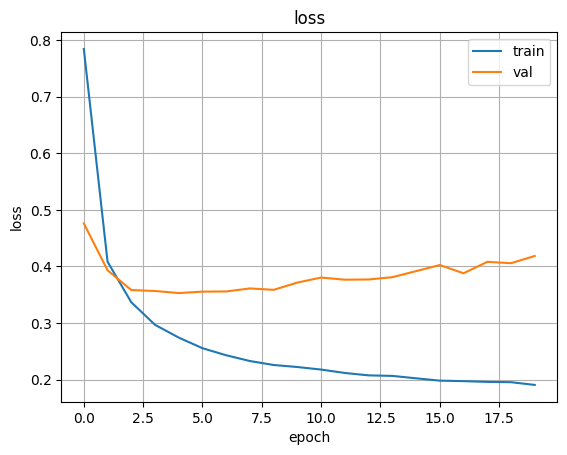

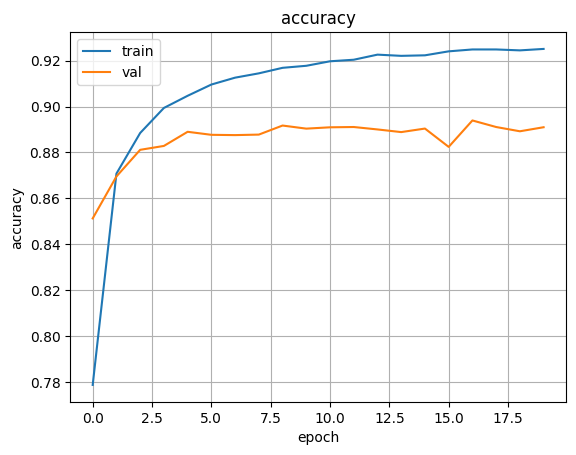

In [65]:
# Train
 
lstm_dense_training_info = {
    'verbose': 0,
    'epochs' : 20,
    'batch_size' : 64
}

lstm_dense_model = train_model(model=lstm_dense_model,training_info = lstm_dense_training_info, name="lstm_dense")

In [66]:
loss, accuracy = lstm_dense_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

lstm_dense_score = compute_f1(lstm_dense_model, x_val, y_val)
print(f'F1_score on the validation set is: {lstm_dense_score}')

lstm_dense_score = compute_f1(lstm_dense_model, x_test, y_test)
print(f'F1_score on the test set is: {lstm_dense_score}')

975/975 [==============================] - 4s 4ms/step - loss: 0.4186 - accuracy: 0.8910
Model loss: 0.418565034866333, accuracy: 0.8909983038902283
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 3s 4ms/step
F1_score on the validation set is: 0.7282929094703651
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 1s 4ms/step
F1_score on the test set is: 0.7956330630509325


## Conclusions

In [67]:
print(f''' 
F1 Macro scores:
    Base (LSTM) = {base_score}
    GRU = {gru_score}
    2x LSTM = {x2lstm_score}
    LSTM + Dense = {lstm_dense_score}
''')

 
F1 Macro scores:
    Base (LSTM) = 0.7783847353968951
    GRU = 0.797299904507028
    2x LSTM = 0.783907137981553
    LSTM + Dense = 0.7956330630509325

